### Creating Model 1

* Creating a 1st model for the NFL Play data. The goal is to predict the play type on 4th down.
* Random Forest and gradient boosted trees are the other models

In [2]:
from pyspark.ml import Pipeline  
from pyspark.ml.feature import *  
from pyspark.ml.classification import RandomForestClassifier
import nfl_data_py as nfl
import numpy as np
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTENC
import pandas as pd
from imblearn.combine import SMOTEENN
from DataPipelineFxn import *
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import TrainValidationSplit, ParamGridBuilder
import seaborn as sns
import matplotlib.pyplot as plt
from pyspark.sql import functions as F

In [3]:
# get the spark session and data frame
data = GetSparkDF(include_undersample = True)

2000 done.
2001 done.
2002 done.
2003 done.
2004 done.
2005 done.
2006 done.
2007 done.
2008 done.
2009 done.
2010 done.
2011 done.
2012 done.
2013 done.
2014 done.
2015 done.
2016 done.
2017 done.
2018 done.
2019 done.
2020 done.
2021 done.
2022 done.
2023 done.


/opt/conda/lib/python3.7/site-packages/pyspark/bin/load-spark-env.sh: line 68: ps: command not found
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


24/12/03 22:23:21 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
24/12/03 22:23:40 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.
24/12/03 22:23:41 WARN TaskSetManager: Stage 0 contains a task of very large size (6176 KiB). The maximum recommended task size is 1000 KiB.


24/12/03 22:23:43 WARN TaskSetManager: Stage 3 contains a task of very large size (6176 KiB). The maximum recommended task size is 1000 KiB.


24/12/03 22:23:49 WARN TaskSetManager: Stage 4 contains a task of very large size (2197 KiB). The maximum recommended task size is 1000 KiB.
24/12/03 22:23:53 WARN TaskSetManager: Stage 5 contains a task of very large size (1216 KiB). The maximum recommended task size is 1000 KiB.


In [4]:
spark, df, test_df, undersample_df = data

### Create numeric columns list for the pipeline

In [5]:
numeric_cols = []
for field in df.schema.fields:
    if str(field.dataType) != "StringType()":
        numeric_cols.append(field.name)
        
numeric_cols.remove("season")
numeric_cols.remove("week")

In [6]:
print(numeric_cols)

['yardline_100', 'quarter_seconds_remaining', 'half_seconds_remaining', 'game_seconds_remaining', 'down', 'drive', 'qtr', 'ydstogo', 'posteam_timeouts_remaining', 'defteam_timeouts_remaining', 'posteam_score', 'defteam_score', 'score_differential', 'ep', 'epa', 'wind', 'temp']


### Create the Model Pipeline

In [7]:

str_col = ["home_team", "away_team", "season_type", "posteam", "posteam_type", "defteam", "side_of_field", "game_half", "week",
        "play_type", "season", 'roof', 'surface']
str_col_output = ["home_team_idx", "away_team_idx", "season_type_idx", "posteam_idx", "posteam_type_idx", "defteam_idx", "week_idx",
                  "side_of_field_idx", "game_half_idx", "play_type_idx", "season_idx", 'roof_idx', 'surface_idx']
ohe_col_input = ["home_team_idx", "away_team_idx", "season_type_idx", "posteam_idx", "posteam_type_idx", "defteam_idx", "week_idx",
                  "side_of_field_idx", "game_half_idx", "season_idx", 'roof_idx', 'surface_idx']
ohe_col_vec = ["home_team_vec", "away_team_vec", "season_type_vec", "posteam_vec", "posteam_type_vec", "defteam_vec", "week_vec",
                  "side_of_field_vec", "game_half_ivec", "season_vec", 'roof_vec', 'surface_vec']

# Combine numeric and one-hot encoded columns
va_input_cols = numeric_cols + ohe_col_vec

# process using string indexer first for catgeorical features  
stringIndexer = StringIndexer(inputCols=str_col, outputCols=str_col_output)

# process rating data into second feature
ohe = OneHotEncoder(inputCols=ohe_col_input, outputCols=ohe_col_vec) 


# Assemble features column
va = VectorAssembler(inputCols=va_input_cols, outputCol="features", handleInvalid = "skip")

# process data using maxabs scaler, not necessarily important for trees but consistency
scaler = MaxAbsScaler(inputCol="features", outputCol="scaledFeatures")

# define the model

#spark.conf.set("spark.speculation", "false")
# Use Random Forest Classifier
rf = RandomForestClassifier(labelCol='play_type_idx', 
                             featuresCol='scaledFeatures', 
                             seed=42)


# Fit the pipeline
pipeline = Pipeline(stages=[stringIndexer, ohe, va, scaler, rf])

In [8]:

# Set up hyperparameter tuning
paramGrid = ParamGridBuilder()\
    .addGrid(rf.numTrees, [10, 50, 100])\
    .addGrid(rf.maxDepth, [5, 10, 15])\
    .addGrid(rf.impurity, ["gini", "entropy"])\
    .build()


# build the evaluator
evaluator = MulticlassClassificationEvaluator(
    predictionCol="prediction",
    labelCol="play_type_idx",
    metricName="accuracy"
)

# set up the train validation split
tvs = TrainValidationSplit(
    estimator=pipeline,
    evaluator=evaluator,
    estimatorParamMaps=paramGrid,
    # 80% of the data will be used for training, 20% for validation.
    trainRatio=0.8
)

In [9]:
df.select(df.roof).distinct().show()

24/12/03 21:50:21 WARN TaskSetManager: Stage 6 contains a task of very large size (6176 KiB). The maximum recommended task size is 1000 KiB.
+--------+
|    roof|
+--------+
|outdoors|
|  closed|
|    open|
|    dome|
+--------+



In [4]:
# need to replace the empty string in surface
undersample_df = undersample_df.withColumn(
    'surface',
    F.when(undersample_df.surface == '', 'Undefined').otherwise(undersample_df.surface)
)

# fit the model with the hyperparameter search
rf_model = tvs.fit(undersample_df)

NameError: name 'undersample_df' is not defined

### Evaluate the Model

In [3]:
best_model = rf_model.bestModel

# Extract the parameter map of the best model
best_params = best_model.stages[-1].extractParamMap()

# Print the parameters values
print("Tuned Parameters of the Best Model:")
for param, value in best_params.items():
    print(f"{param.name}: {value}")

NameError: name 'rf_model' is not defined

In [11]:
# have to change test df instance
test_df = test_df.withColumn(
    'surface',
    F.when(test_df.surface == '', 'Undefined').otherwise(test_df.surface)
)

prediction = best_model.transform(test_df)


In [12]:
f1_evaluator = MulticlassClassificationEvaluator(
    labelCol='play_type_idx', predictionCol="prediction",
    metricName='f1'
)

accuracy_evaluator = MulticlassClassificationEvaluator(
    labelCol='play_type_idx', predictionCol="prediction",
    metricName='accuracy'
)

precision_by_label_eval = MulticlassClassificationEvaluator(
    labelCol='play_type_idx', predictionCol="prediction",
    metricName='precisionByLabel'
)

f1_score = f1_evaluator.evaluate(prediction)
accuracy = accuracy_evaluator.evaluate(prediction)
precision_by_label = precision_by_label_eval.evaluate(prediction)

24/12/03 22:28:43 WARN TaskSetManager: Stage 622 contains a task of very large size (6176 KiB). The maximum recommended task size is 1000 KiB.


24/12/03 22:28:44 WARN TaskSetManager: Stage 623 contains a task of very large size (6176 KiB). The maximum recommended task size is 1000 KiB.


24/12/03 22:28:47 WARN DAGScheduler: Broadcasting large task binary with size 29.0 MiB


24/12/03 22:28:53 WARN TaskSetManager: Stage 632 contains a task of very large size (6176 KiB). The maximum recommended task size is 1000 KiB.
24/12/03 22:28:53 WARN TaskSetManager: Stage 633 contains a task of very large size (6176 KiB). The maximum recommended task size is 1000 KiB.


24/12/03 22:28:56 WARN DAGScheduler: Broadcasting large task binary with size 29.0 MiB


24/12/03 22:29:00 WARN TaskSetManager: Stage 642 contains a task of very large size (6176 KiB). The maximum recommended task size is 1000 KiB.
24/12/03 22:29:00 WARN TaskSetManager: Stage 643 contains a task of very large size (6176 KiB). The maximum recommended task size is 1000 KiB.


24/12/03 22:29:03 WARN DAGScheduler: Broadcasting large task binary with size 29.0 MiB


In [ ]:
scoreAndLabels = sc.parallelize([
    ([0.0, 1.0], [0.0, 2.0]),
    ([0.0, 2.0], [0.0, 1.0]),
    ([], [0.0]),
    ([2.0], [2.0]),
    ([2.0, 0.0], [2.0, 0.0]),
    ([0.0, 1.0, 2.0], [0.0, 1.0]),
    ([1.0], [1.0, 2.0])])

# Instantiate metrics object
metrics = MultilabelMetrics(scoreAndLabels)

# Summary stats
print("Recall = %s" % metrics.recall())
print("Precision = %s" % metrics.precision())
print("F1 measure = %s" % metrics.f1Measure())
print("Accuracy = %s" % metrics.accuracy)

# Individual label stats
labels = scoreAndLabels.flatMap(lambda x: x[1]).distinct().collect()
for label in labels:
    print("Class %s precision = %s" % (label, metrics.precision(label)))
    print("Class %s recall = %s" % (label, metrics.recall(label)))
    print("Class %s F1 Measure = %s" % (label, metrics.f1Measure(label)))

In [ ]:
prediction.select([prediction.play_type_idx, prediction.prediction]).show(10)

In [ ]:
prediction.groupby(prediction.prediction).count().show()

In [ ]:
prediction.groupby(prediction.play_type_idx).count().show()

In [13]:
labels = prediction.select([prediction.play_type, prediction.play_type_idx]).distinct().orderBy(prediction.play_type_idx).select(prediction.play_type).collect()
labels = [x(0) for x in labels]

24/12/03 22:29:19 WARN TaskSetManager: Stage 652 contains a task of very large size (6176 KiB). The maximum recommended task size is 1000 KiB.
24/12/03 22:29:20 WARN TaskSetManager: Stage 653 contains a task of very large size (6176 KiB). The maximum recommended task size is 1000 KiB.


In [ ]:
test_df.groupby(test_df.play_type).count().show()

In [14]:
results = f'''
F1: {f1_score}
Accuracy: {accuracy}
Precision by Label: {precision_by_label}
'''

print(results)


F1: 0.8592622298977846
Accuracy: 0.843362291118727
Precision by Label: 0.8865755127408328



In [15]:
from pyspark.sql.types import FloatType
from pyspark.mllib.evaluation import MulticlassMetrics

#Adapting code from https://www.kaggle.com/code/ashokkumarpalivela/multiclass-classification-using-pyspark for confusion matrix
preds_and_labels = prediction.select(['prediction','play_type_idx'])\
                              .withColumn('play_type_idx', col('play_type_idx')\
                              .cast(FloatType()))\
                              .orderBy('prediction')
    
metrics = MulticlassMetrics(preds_and_labels.rdd.map(tuple))

print(metrics.confusionMatrix().toArray())

24/12/03 22:29:43 WARN TaskSetManager: Stage 677 contains a task of very large size (6176 KiB). The maximum recommended task size is 1000 KiB.
24/12/03 22:29:44 WARN TaskSetManager: Stage 678 contains a task of very large size (6176 KiB). The maximum recommended task size is 1000 KiB.


24/12/03 22:29:47 WARN DAGScheduler: Broadcasting large task binary with size 29.0 MiB


24/12/03 22:29:52 WARN DAGScheduler: Broadcasting large task binary with size 29.0 MiB


/opt/conda/lib/python3.7/site-packages/pyspark/sql/context.py:159: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning,


24/12/03 22:29:56 WARN DAGScheduler: Broadcasting large task binary with size 28.9 MiB


24/12/03 22:29:57 WARN DAGScheduler: Broadcasting large task binary with size 28.9 MiB


[[5.7060e+03 3.8000e+01 2.9900e+02 1.3000e+01 2.0700e+02]
 [1.9700e+02 2.4100e+02 1.8300e+02 5.9100e+02 1.5900e+02]
 [2.1800e+02 5.3000e+01 1.7350e+03 4.7000e+01 3.1900e+02]
 [2.3600e+02 2.0120e+03 5.3500e+02 2.2967e+04 4.3700e+02]
 [7.9000e+01 3.0000e+01 1.8000e+02 6.3000e+01 1.0960e+03]]


Text(95.5815972222222, 0.5, 'Actual')

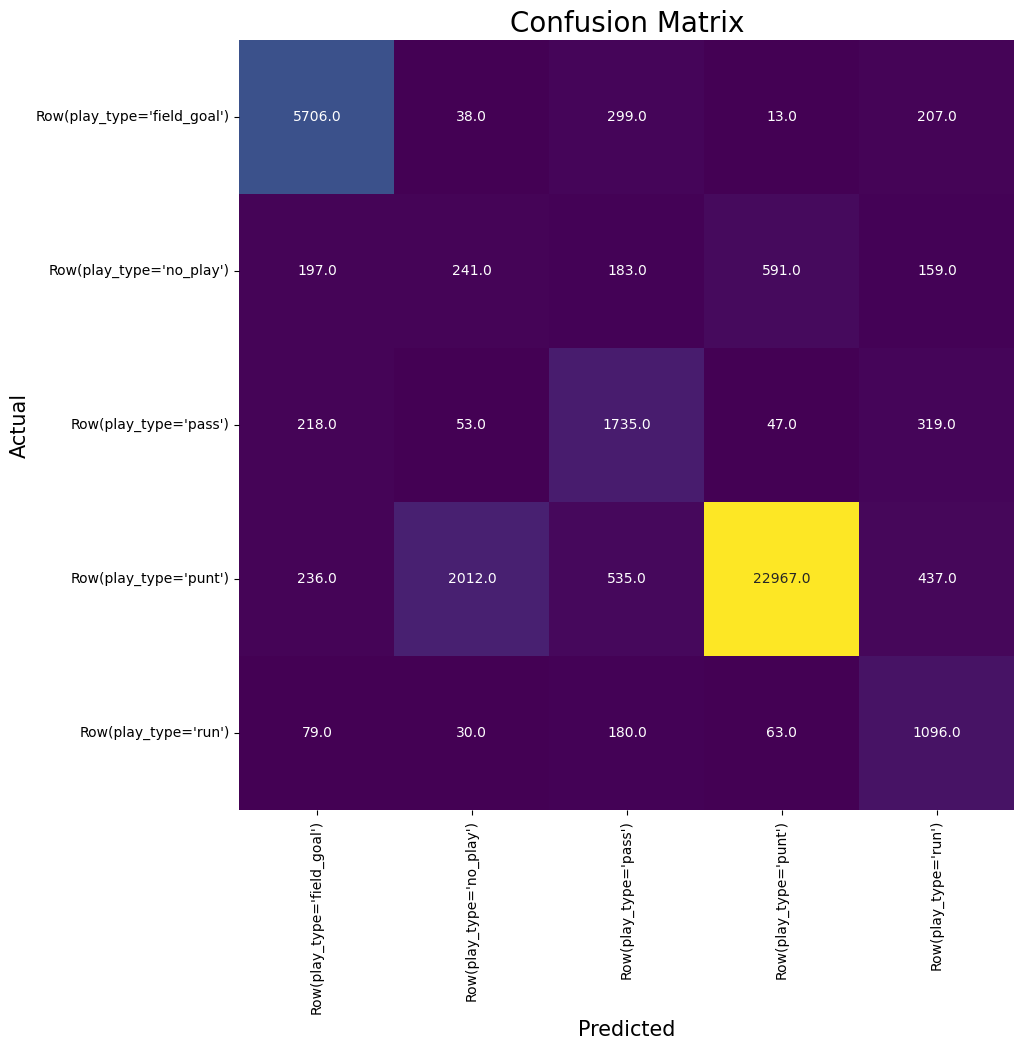

In [16]:
# labels = ["field_goal", "no_play", "pass", "punt", "run"]
_ = plt.figure(figsize=(10, 10))
ax = sns.heatmap(metrics.confusionMatrix().toArray(),
            cmap='viridis',
            annot=True,fmt='0',
            cbar=False, 
            xticklabels=labels,
            yticklabels=labels)

plt.title('Confusion Matrix', fontsize = 20) # title with fontsize 20
plt.xlabel('Predicted', fontsize = 15) # x-axis label with fontsize 15
plt.ylabel('Actual', fontsize = 15) # y-axis label with fontsize 15

### Conclusions

Some quick observations:

* Much better performance when we don't undersample, could be because everything is a punt
* We need to be careful with the labels for the confusion matrix. They were not intially lining up properly with what the idxs are.
* I added temp, wind, roof, surface to the predictors